In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from numpy.fft import fft, ifft, fftfreq, fftshift
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.special import erf
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from propagation import laser
from ionization import ionization
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt
from lens import design
plt.style.use('notes')

path = '/mnt/md0/Data/rariniello/Lithium_Oven/Lithium_Oven_Optic_4/'
lam = 0.796
# All length units are in um

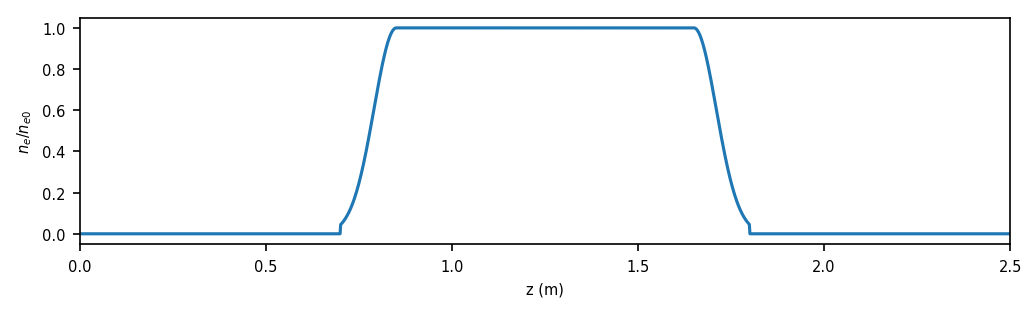

In [2]:
# Distance from picnic basket to oven start is 12in flange to flange
# Assume protected gold mirror for the final mirror
# Plasma density of 3.4e16 
# Plasma length is 60cm
# Ramp length we will estimate as 15cm each, beam should fully ionize this region
# There is 36in from the start of the flattop to the edge of the picnic basket
# Assume 0 is the dge of the picnic basket and the flattop is 1m downstream
length = 80e4
width = 80

# The optic positioning is very flexible

# Create the grid for the setup
Nz = 2**16
Z = 100e6 # Needs to be very large to provide resolution in the frequency domain
z, dz = np.linspace(0, Z, Nz, retstep=True)
frac_l = np.zeros(Nz, dtype='double')

# On axis plasma density profile is given by
# Uniform accelerating plasma
z0 = 0.85e6 # start of the uniform plasma
sel_u = np.logical_and(z > z0, z < z0+length)
frac_l[sel_u] = 1.0

# Entrance ramp
l_ent = 15e4 # length of the entrance ramp
s_ent = 6e4
sel_ent = np.logical_and(z >= z0-l_ent, z <= z0)
ramp_ent = np.exp(-(z-z0)**2/(2*s_ent**2))
frac_l[sel_ent] = ramp_ent[sel_ent]

#Exit ramp
l_ext = 15e4 # length of the entrance ramp
s_ext = 6e4
sel_ext = np.logical_and(z >= z0+length, z <= z0+length+l_ext)
ramp_ext = np.exp(-(z-z0-length)**2/(2*s_ext**2))
frac_l[sel_ext] = ramp_ext[sel_ext]

xlim = [0, 2.5]
#xlim = [2.4, 4]
#xlim = [3.25, 4]
#xlim = [2, 2.5]
plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z/1e6, frac_l)
plt.xlabel(r'z (m)')
plt.ylabel(r'$n_e/n_{e0}$')
plt.xlim(xlim)
plt.show()

np.save(path+'plasma.npy', [z, frac_l])

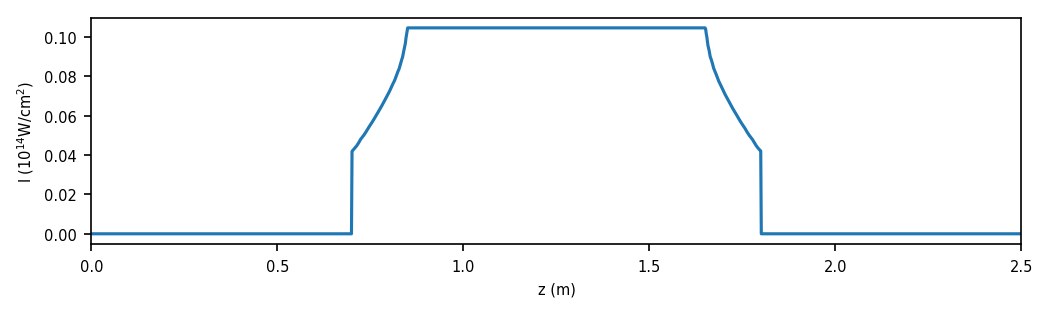

In [3]:
# Calculate the desired on axis intensity profile from the ionization fraction
# Assume a pulse with a Gaussian temporal shape
tau = 30 # RMS pulse length in fs
ion = {'atom' : ionization.Li,
       'tau' : tau,
       'type' : 'gaussian'}
I_l = ionization.intensity_from_density(ion, 0.999*frac_l)

plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z/1e6, I_l)
plt.xlabel(r'z (m)')
plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
plt.xlim(xlim)
plt.show()

Plasma starts at 0.32m and ends at 2.25m


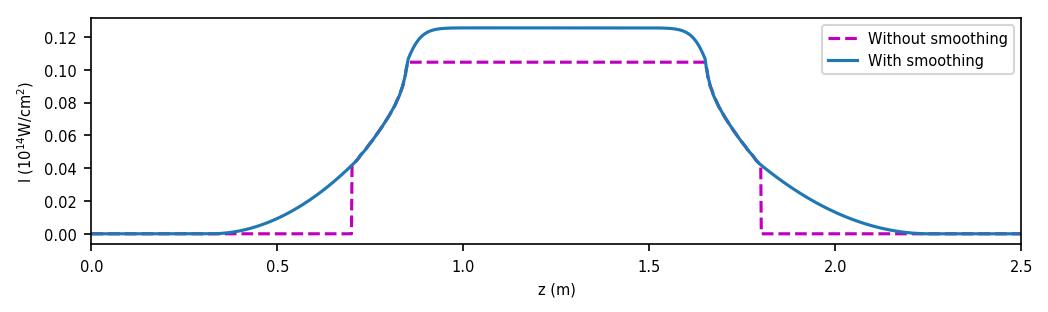

In [4]:
# The intensity profile needs to be smoothed to remove steps and hard corners

# Smooth the center section and increase the intensity
order = 8
Imax = np.amax(I_l)
z_u = z[sel_u]
zc = 0.5*(z_u[-1] + z_u[0])
w = (z_u[0] - zc)**(2*order)/0.6
I_la = np.copy(I_l)
I_new = 0.4*Imax*(np.exp(-(z_u - zc)**(2*order)/w)-0.5)
I_la[sel_u] += I_new

#Smooth the beginning of the entrance ramp with a parabola
I_ent = I_l[sel_ent]
gradI = (I_ent[1] - I_ent[0]) / dz
A = gradI**2 / (4*I_ent[0])
B = z[sel_ent][0] - 2*I_ent[0]/gradI
sel = np.logical_and(z >= B, z < z0-l_ent)
I_la[sel] = A*(z[sel]-B)**2
I_la[z < B] = 0.0
plasma_start = B

#Smooth the end of the exit ramp with a parabola
I_ext = I_l[sel_ext]
gradI = (I_ext[-1] - I_ext[-2]) / dz
A = gradI**2 / (4*I_ext[-1])
B = z[sel_ext][-1] - 2*I_ext[-1]/gradI
sel = np.logical_and(z <= B, z > z0+length+l_ext)
I_la[sel] = A*(z[sel]-B)**2
I_la[z > B] = 0.0
plasma_end = B

print('Plasma starts at %0.2fm and ends at %0.2fm' % (plasma_start/1e6, plasma_end/1e6))
plasma_size = [plasma_start, plasma_end]
np.save(path+'plasma_size.npy', plasma_size)

plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z/1e6, I_l, '--m')
plt.plot(z/1e6, I_la)
plt.legend(['Without smoothing', 'With smoothing'])
plt.xlabel(r'z (m)')
plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
plt.xlim(xlim)
plt.show()

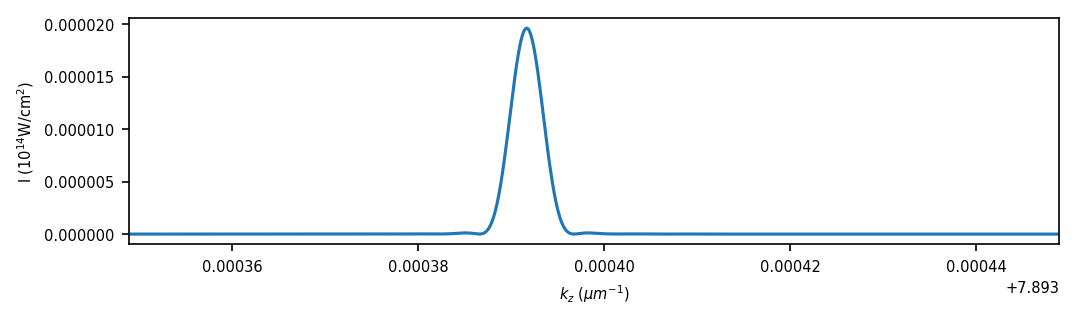

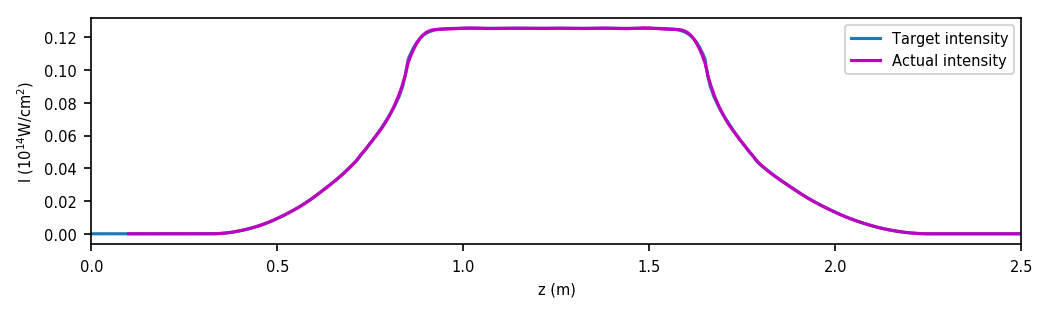

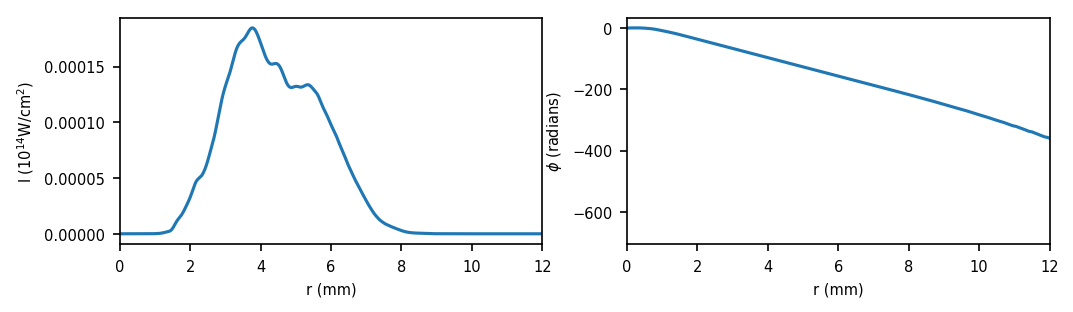

In [5]:
r, E = design.calculate_tran_field(z, I_la, 20e3, width, lam, 10e-5, xlim, [0, 12])

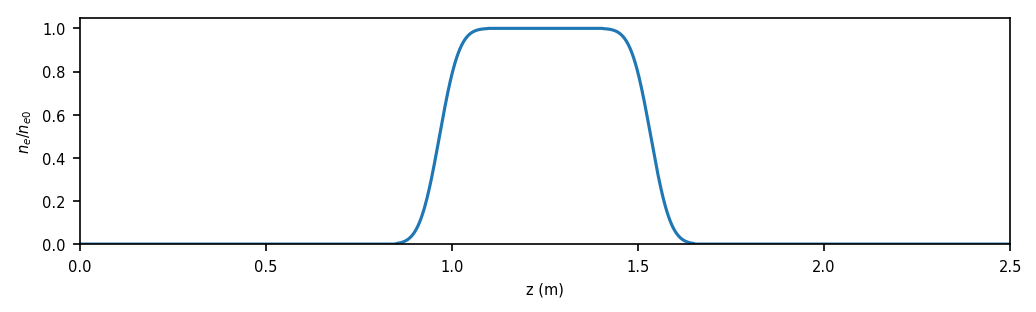

In [6]:
# Create the gas density the laser is going into
Nz = 2**16
n = np.zeros(Nz, dtype='double')
ne0 = 3.4e16/1e17
# Error function ramps?
# Uniform accelerating plasma
length = 30.8e4
z0 = -length/2+1.25e6 # start of the uniform plasma
sel_u = np.logical_and(z > z0, z < z0+length)
n[sel_u] = 1.0

# Entrance ramp
l_ent = 40e4-length/2 # length of the entrance ramp
s_ent = 4.2e4
sel_ent = np.logical_and(z >= z0-l_ent, z <= z0)
ramp_ent = 0.5*(1+erf((z-z0+13e4)/(np.sqrt(2)*s_ent)))
n[sel_ent] = ramp_ent[sel_ent]

#Exit ramp
l_ext = 40e4-length/2 # length of the entrance ramp
s_ext = 4.2e4
sel_ext = np.logical_and(z >= z0+length, z <= z0+length+l_ext)
ramp_ext = 0.5*(1+erf(-(z-z0-13e4-length)/(np.sqrt(2)*s_ent)))
n[sel_ext] = ramp_ext[sel_ext]

plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z/1e6, n)
plt.xlabel(r'z (m)')
plt.ylabel(r'$n_e/n_{e0}$')
plt.xlim(xlim)
plt.ylim(0, 1.05)
plt.show()
# Find the start for the refraction code
start = z0-l_ent
n = interp1d(z, n*ne0)

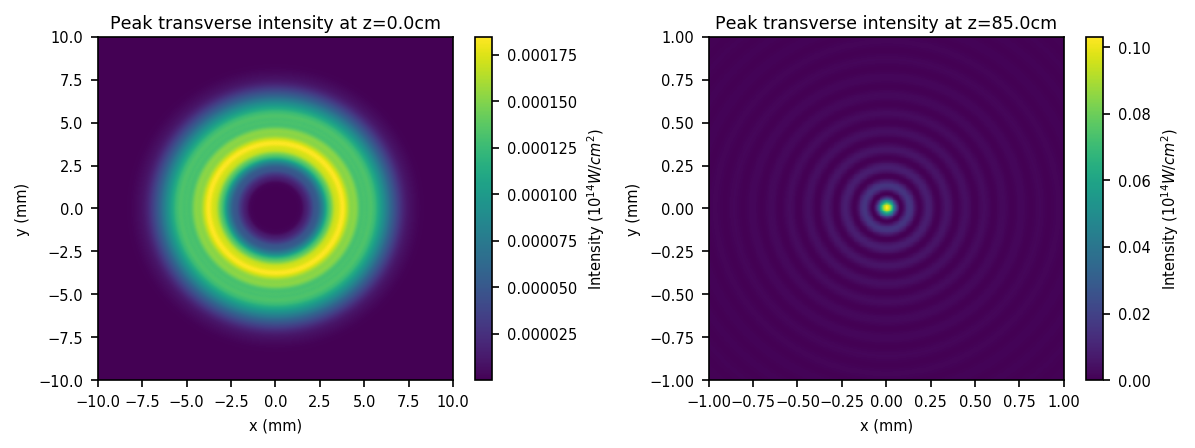

In [7]:
start = z0-l_ent
X = 20e3
Nx = 2**12
beam0, pulseParams = design.propagate_to_start(r, E, start, X, Nx, path, lam, tau, 20, [-1, 1])

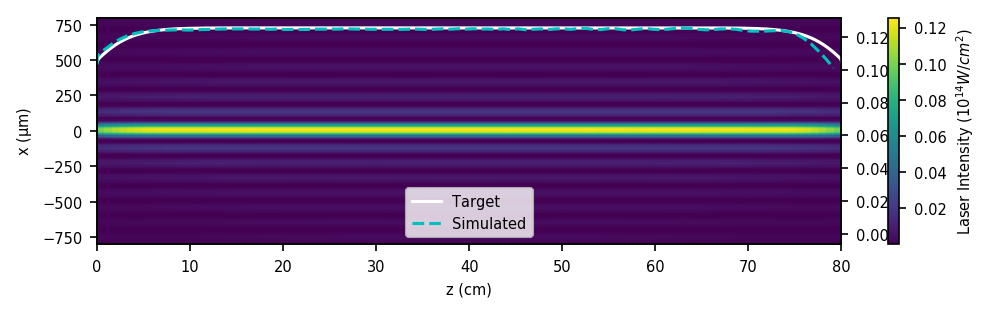

In [8]:
Nx = 2**10
Nz = 100
X = 9e3
Z = 80e4
design.domain_test(X, Nx, Z, Nz, beam0, pulseParams, z, I_la, start, [-800, 800])

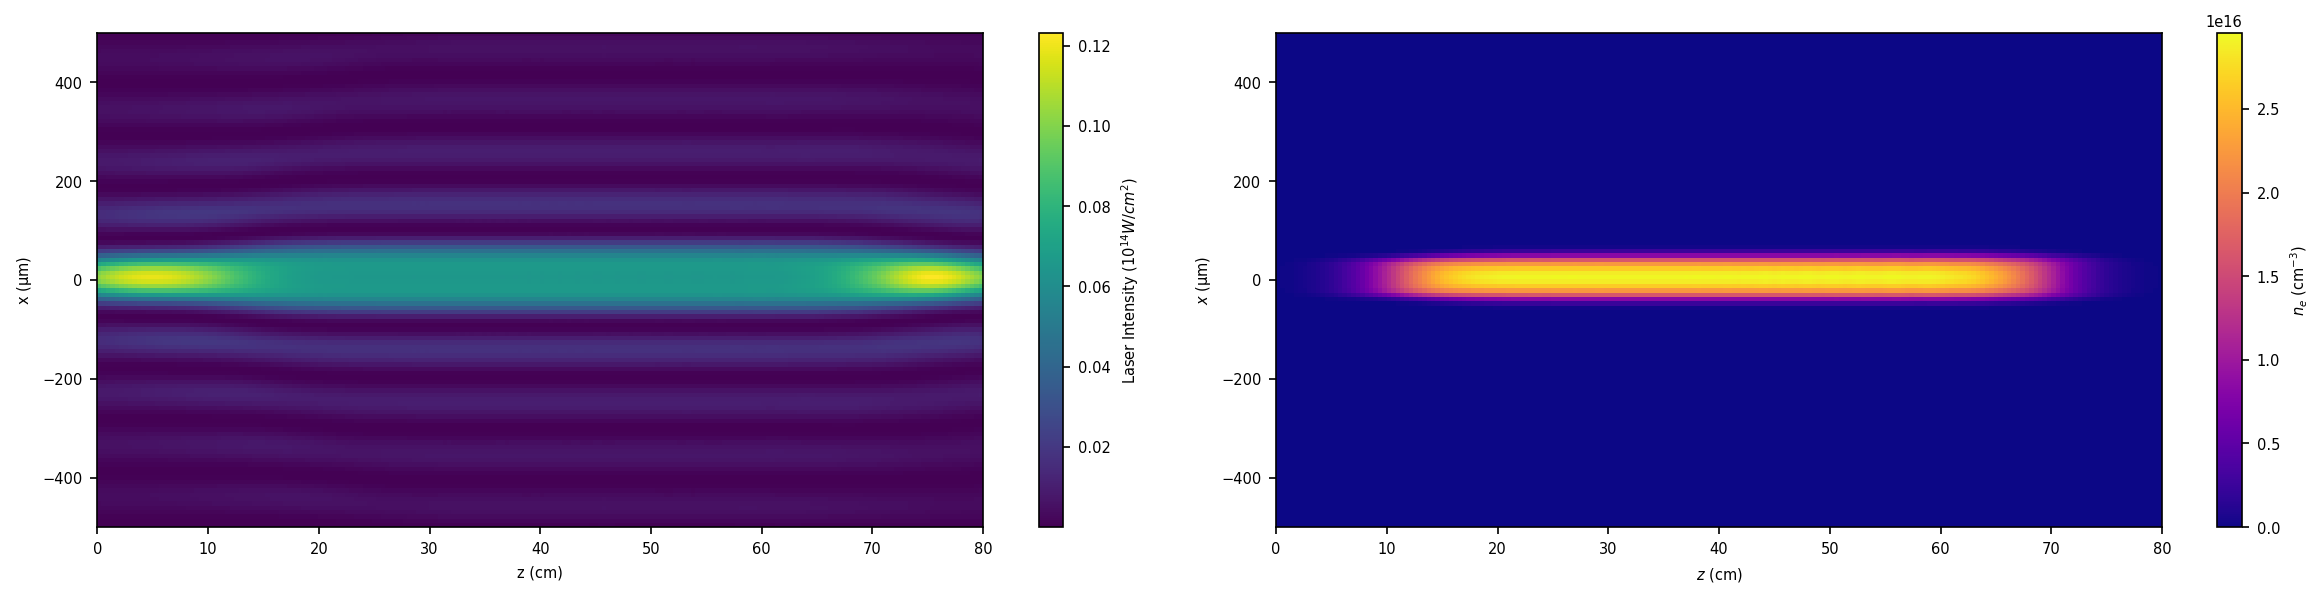

In [9]:
Nx = 2**10
Nz = 200
Z = 80e4
ext = [0, Z/1e4, -X/2, X/2]
pulse, I, ne = design.plasma_refraction(X, Nx, Z, Nz, beam0, pulseParams, ionization.Li, n, start, 1)
design.plot_laser_plasma(I, ne, ext)

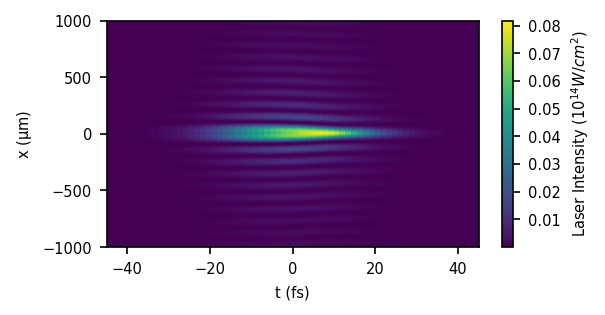

Frame 30 completed
Frame 60 completed
Frame 90 completed
Frame 120 completed
Frame 150 completed
Frame 180 completed


In [10]:
design.plot_pulse(pulse, 100, [-1000, 1000], False)
design.pulse_evolution(pulse, '80um_base', [-500, 500], False)

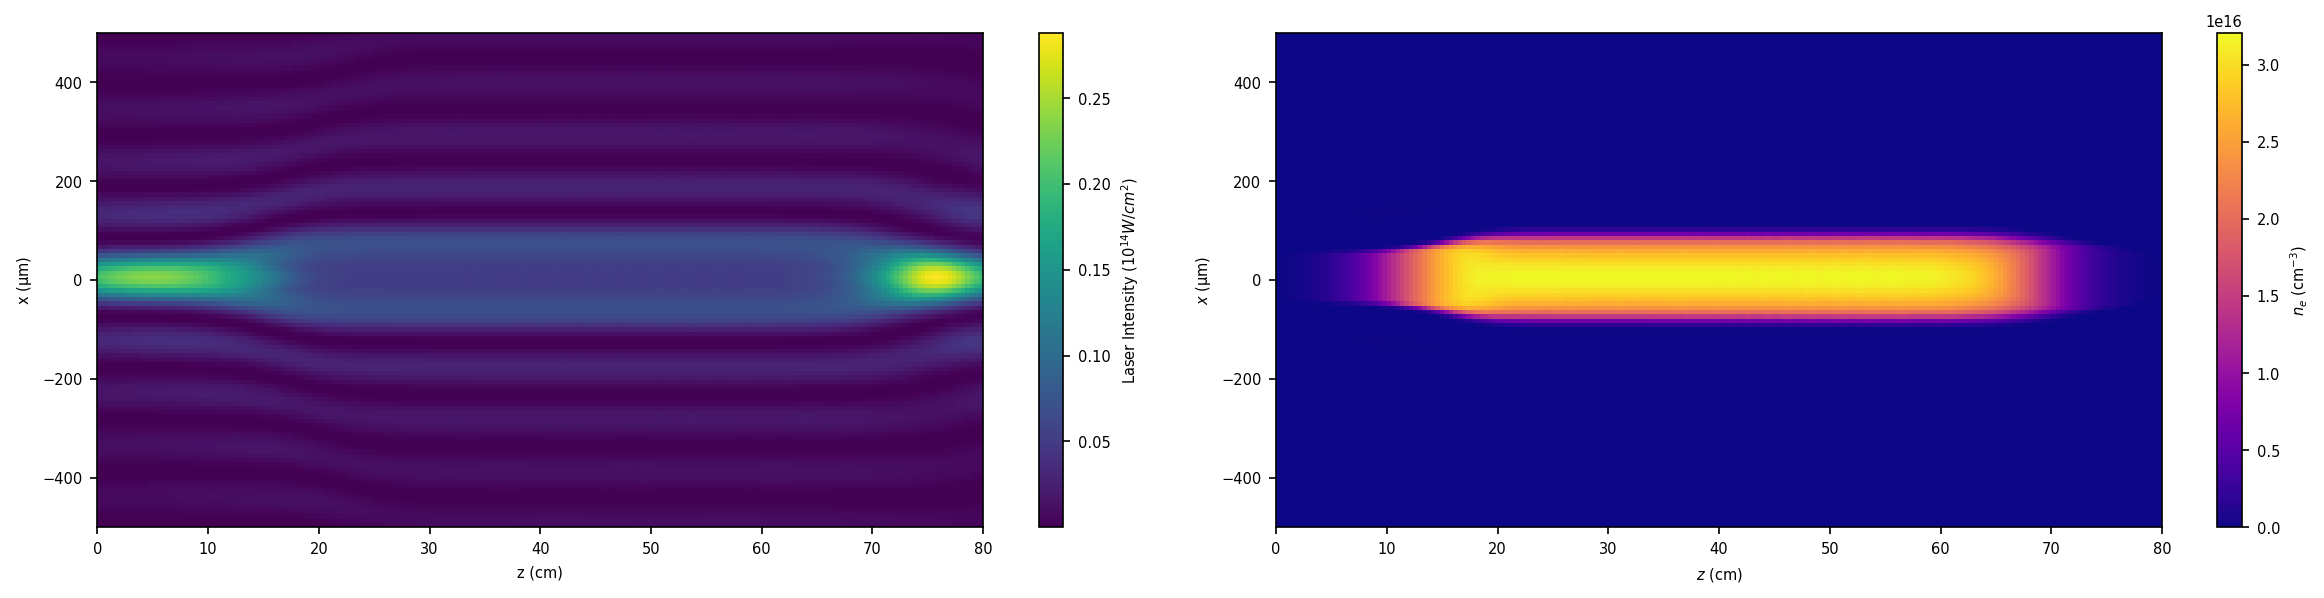

In [11]:
Nx = 2**10
Nz = 200
Z = 80e4
ext = [0, Z/1e4, -X/2, X/2]
pulse, I, ne = design.plasma_refraction(X, Nx, Z, Nz, beam0, pulseParams, ionization.Li, n, start, 2)
design.plot_laser_plasma(I, ne, ext)

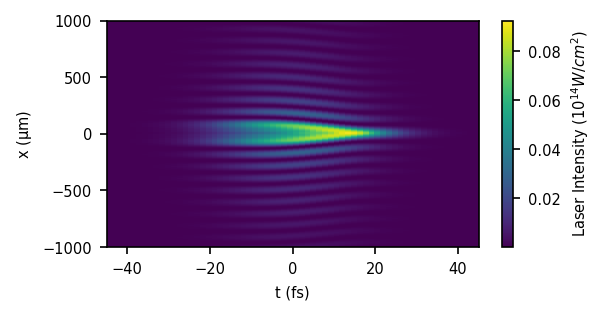

Frame 30 completed
Frame 60 completed
Frame 90 completed
Frame 120 completed
Frame 150 completed
Frame 180 completed


In [12]:
design.plot_pulse(pulse, 100, [-1000, 1000], False)
design.pulse_evolution(pulse, '80um_2XEnergy', [-500, 500], False)

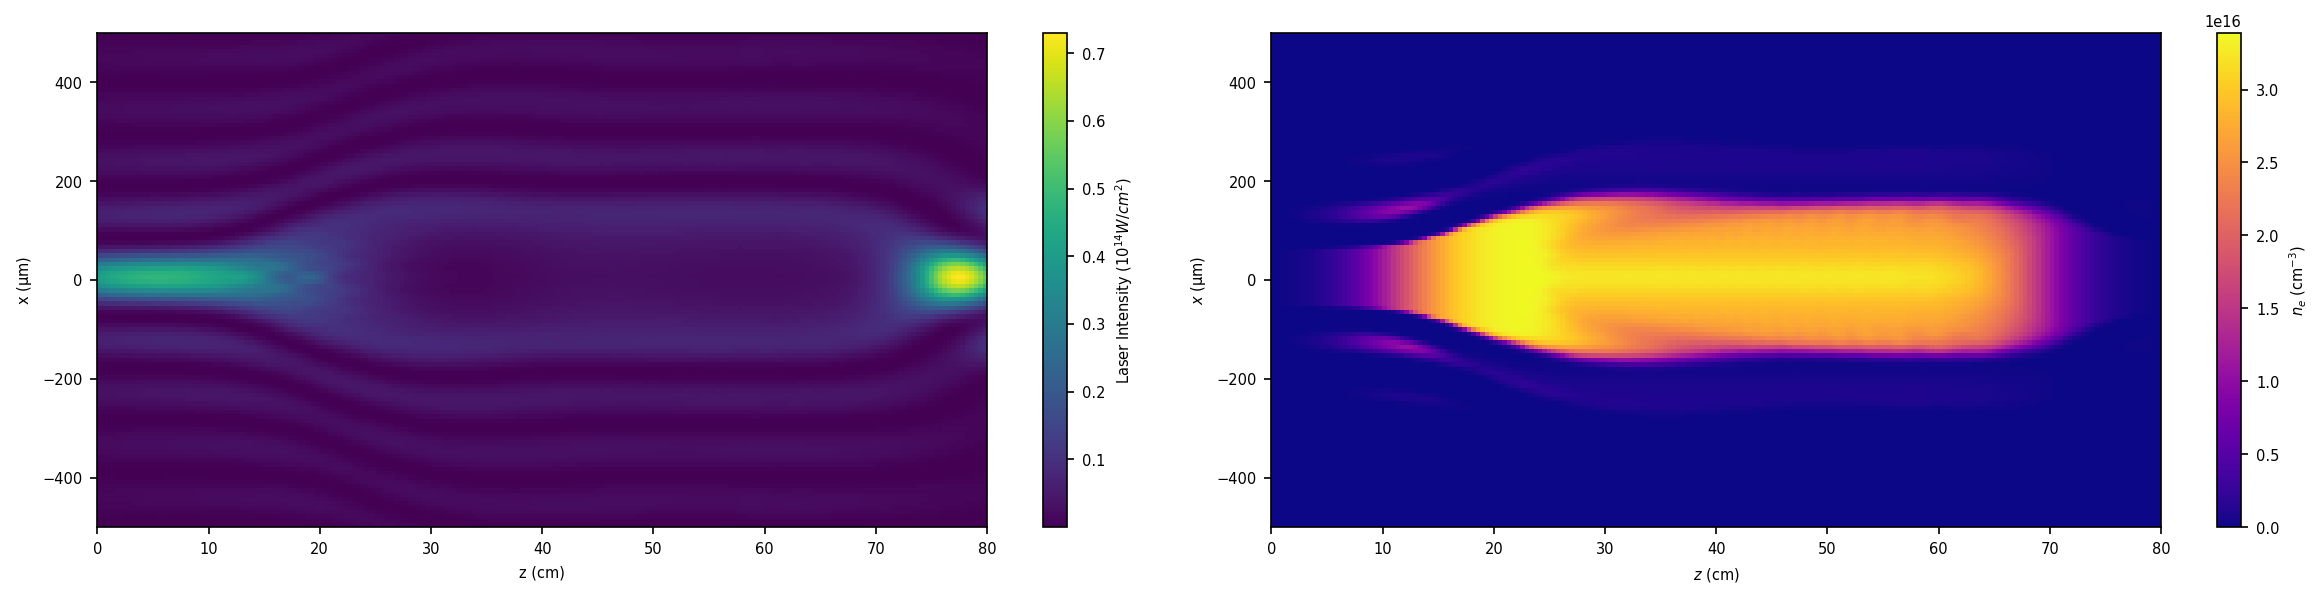

In [13]:
Nx = 2**10
Nz = 200
Z = 80e4
ext = [0, Z/1e4, -X/2, X/2]
pulse, I, ne = design.plasma_refraction(X, Nx, Z, Nz, beam0, pulseParams, ionization.Li, n, start, 4)
design.plot_laser_plasma(I, ne, ext)

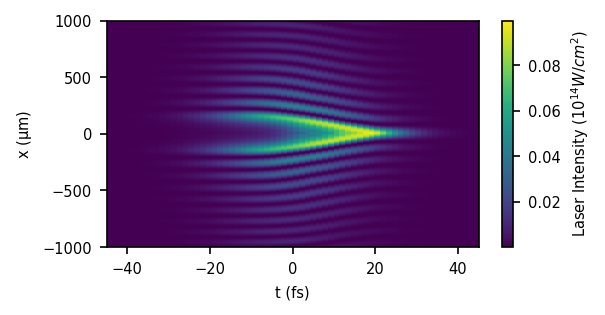

Frame 30 completed
Frame 60 completed
Frame 90 completed
Frame 120 completed
Frame 150 completed
Frame 180 completed


In [14]:
design.plot_pulse(pulse, 100, [-1000, 1000], False)
design.pulse_evolution(pulse, '80um_4XEnergy', [-500, 500], False)

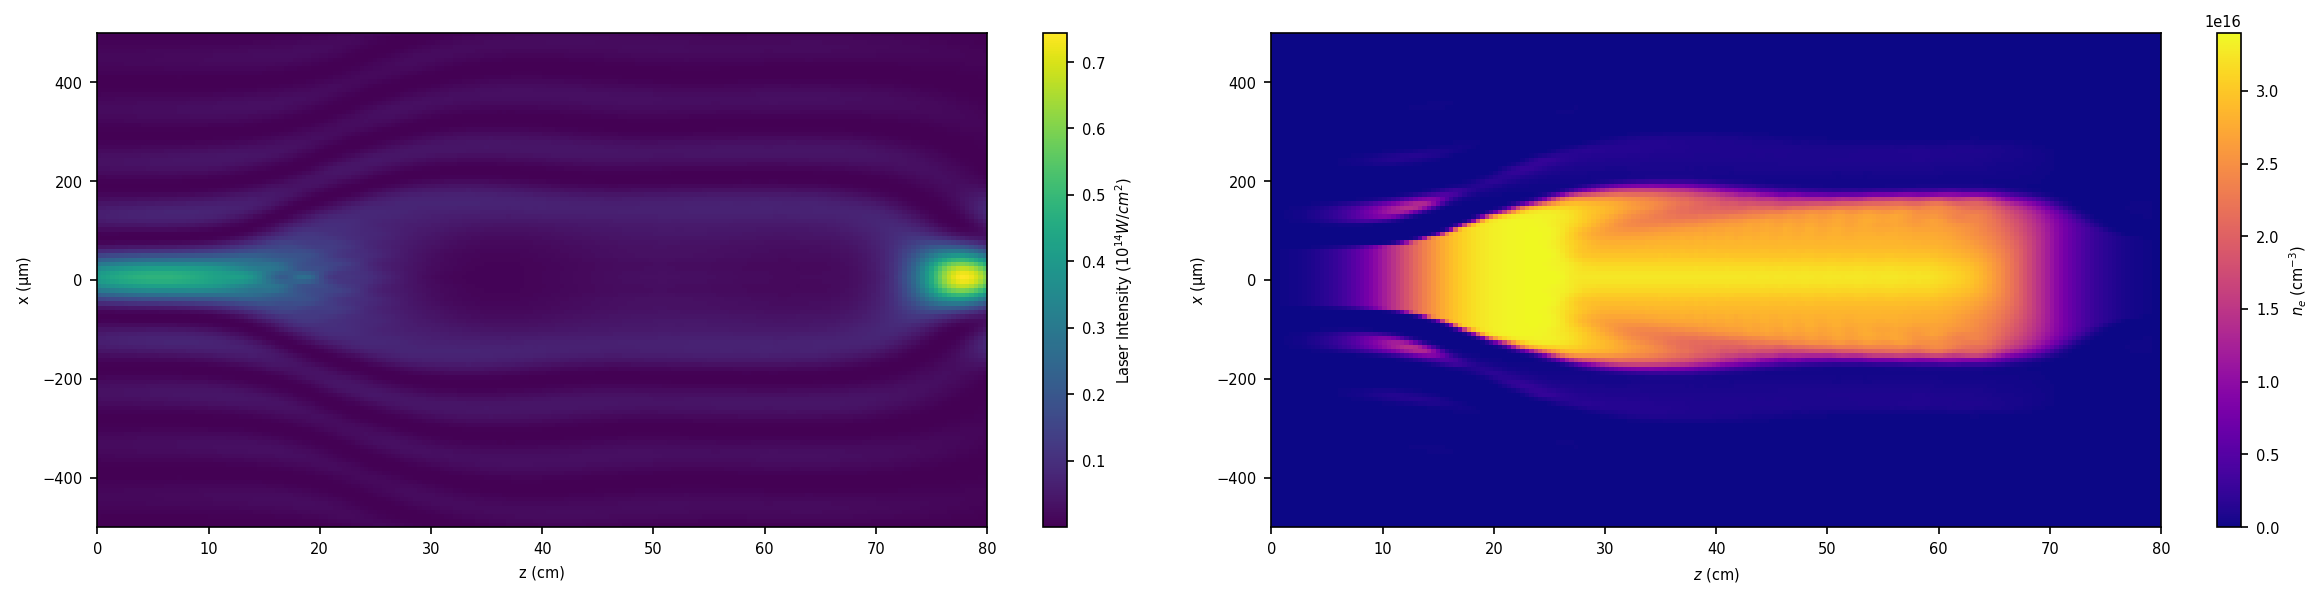

In [16]:
Nx = 2**10
Nz = 200
Z = 80e4
ext = [0, Z/1e4, -X/2, X/2]
tau = 50
pulseParams['tau'] = tau
pulseParams['T'] = 3*tau
pulse, I, ne = design.plasma_refraction(X, Nx, Z, Nz, beam0, pulseParams, ionization.Li, n, start, 4)
design.plot_laser_plasma(I, ne, ext)

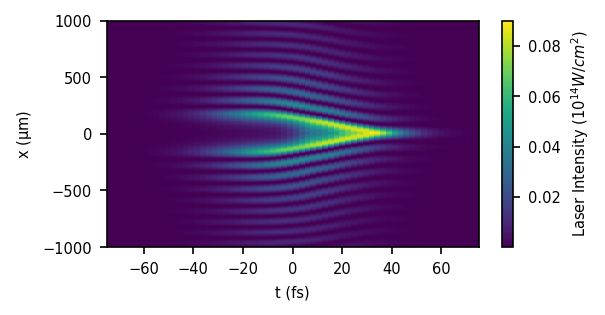

Frame 30 completed
Frame 60 completed
Frame 90 completed
Frame 120 completed
Frame 150 completed
Frame 180 completed


In [17]:
design.plot_pulse(pulse, 100, [-1000, 1000], False)
design.pulse_evolution(pulse, '80um_4XEnergy_50fs', [-500, 500], False)

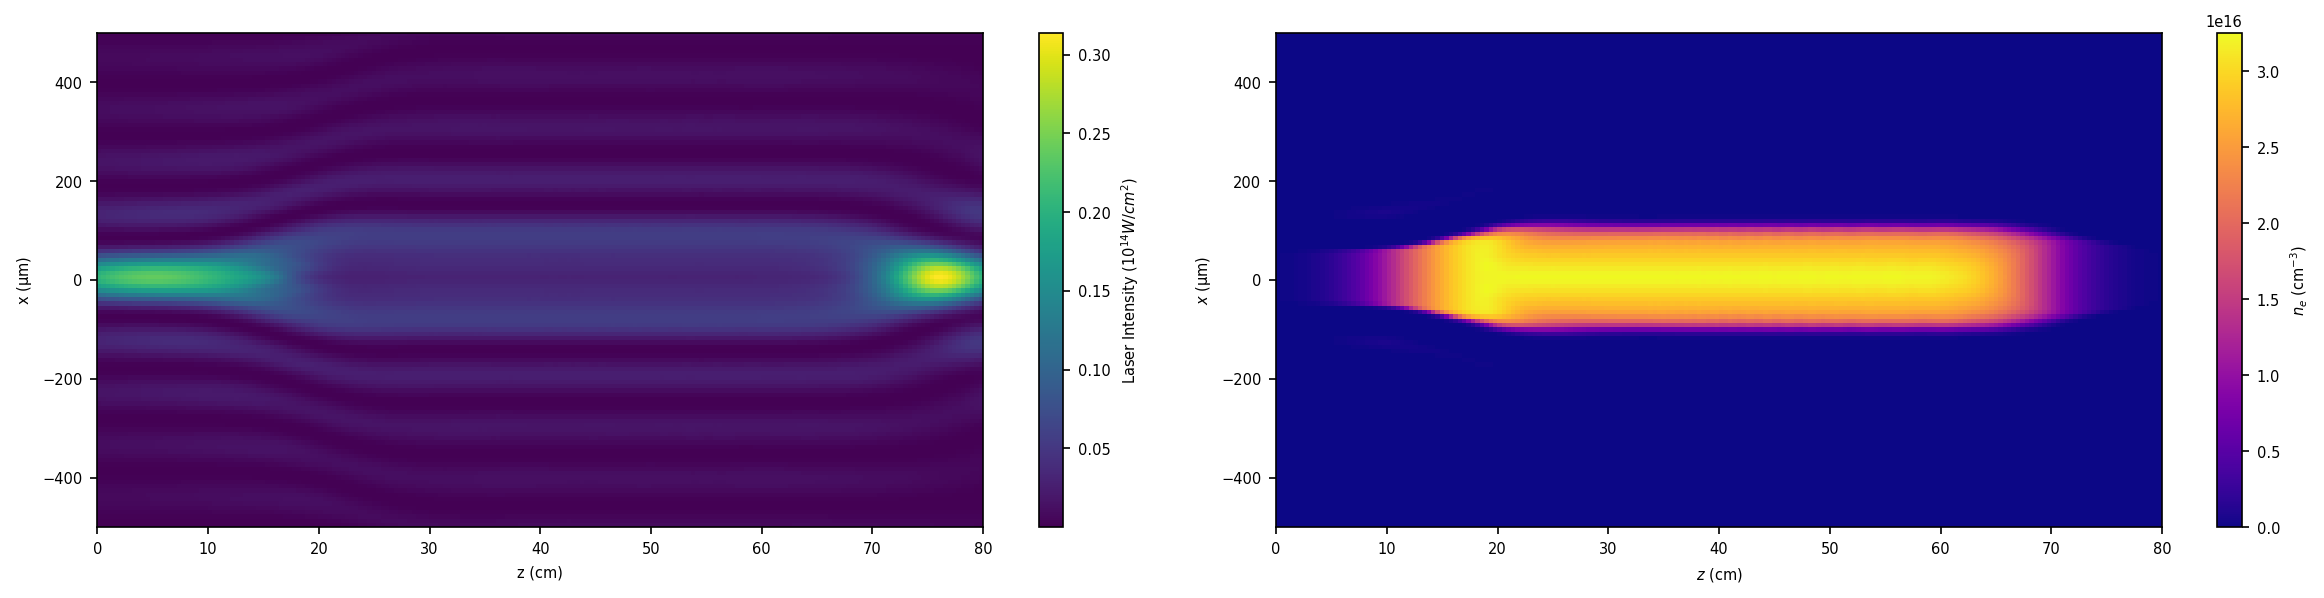

In [18]:
Nx = 2**10
Nz = 200
Z = 80e4
ext = [0, Z/1e4, -X/2, X/2]
tau = 100
pulseParams['tau'] = tau
pulseParams['T'] = 3*tau
pulse, I, ne = design.plasma_refraction(X, Nx, Z, Nz, beam0, pulseParams, ionization.Li, n, start, 2)
design.plot_laser_plasma(I, ne, ext)

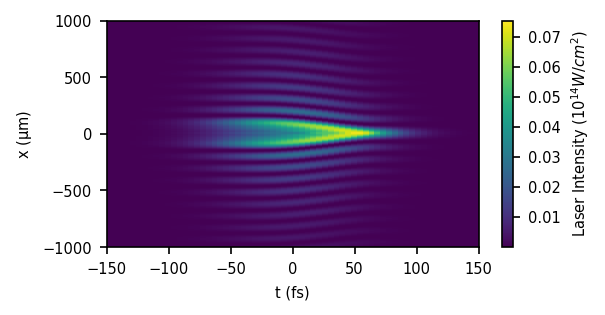

Frame 30 completed
Frame 60 completed
Frame 90 completed
Frame 120 completed
Frame 150 completed
Frame 180 completed


In [19]:
design.plot_pulse(pulse, 100, [-1000, 1000], False)
design.pulse_evolution(pulse, '80um_2XEnergy_100fs', [-500, 500], False)